<a href="https://colab.research.google.com/github/steffenmodest/Python_Examples/blob/main/Kopie_von_iX_Developer_Unsupervised_Learing_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Die gebräuchlichsten Imports

- `numpy`, abgekürzt als `np` für numerische Berechnungen, insbesondere mit Vektoren
- `matplotlib`, abgekürzt als `plt` für eine Matlab-ähnliches Interface zum Zeichnen von Diagrammen.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Einfache Beispieldaten erzeugen

`make_blobs` erzeugt in den Standardeinstellungen 100 Punkte in zwei Dimensionen, zufällig verteilt um drei Mittelpunkte. X enthält die Koordinaten, y ob es aus dem ersten, zweiten oder dritten Mittelpunkt entstanden ist.

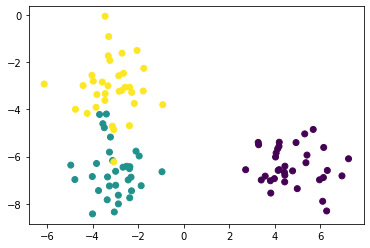

In [ ]:
from sklearn.datasets import make_blobs
X, y = make_blobs(random_state=4223)
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

# Clustering mit K-Means

Wir verwenden eine eigene, simple K-Means Implementierung, damit wir die Zwischenschritte visualisieren können.

In [ ]:
# Hier die Basisfunktionen:

def assignCluster(data, centroids):
    '''
    Gibt für jeden Punkt in data den index des nächstgelegenen Punkt in
    centroids zurück. Damit berechnen wir die membership, weisen also jedem
    Datenpunkt dem nächstgelegenen Cluster zu.
    '''
    membership = np.zeros(len(data), dtype='int64')
    for i in range(len(data)):
        # Euklidische Distanz zu den Zentroiden:
        distances = np.linalg.norm(centroids - data[i], axis=1)
        membership[i] = np.argmin(distances)
    return membership


def KMeans_step(data, centroids, membership):
    '''
    Berechne für jeden Cluster den Mittelpunkt und weise die Datenpunkt neu zu.
    '''

    # Clustermittelpunkt neu berechnen
    for k in range(len(centroids)):
        members = data[membership == k]
        centroids[k] = np.mean(members, axis=0)

    # Punkte den Clustern zuweisen:
    membership = assignCluster(data, centroids)
    return centroids, membership


def plotKMeans(data, centroids, membership):
    'Eine Visualisierungsfunktion für die Zwischenschritte'

    # Daten und Zentroiden einzeichnen
    plt.scatter(data[:,0], data[:,1], c=membership)
    plt.scatter(centroids[:,0], centroids[:,1], c=range(len(centroids)), 
                marker='X', s=200, edgecolors=['w','w','k'])

    # Hintergrundfarbe (nach https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html)
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .1), np.arange(y_min, y_max, .1))
    z = assignCluster(np.c_[xx.ravel(), yy.ravel()], centroids)
    z = z.reshape(xx.shape)
    plt.imshow(z, extent=(xx.min(), xx.max(), yy.min(), yy.max()), alpha=0.2, origin='lower')


Iteration 1: converged: False
Iteration 2: converged: False
Iteration 3: converged: False
Iteration 4: converged: True


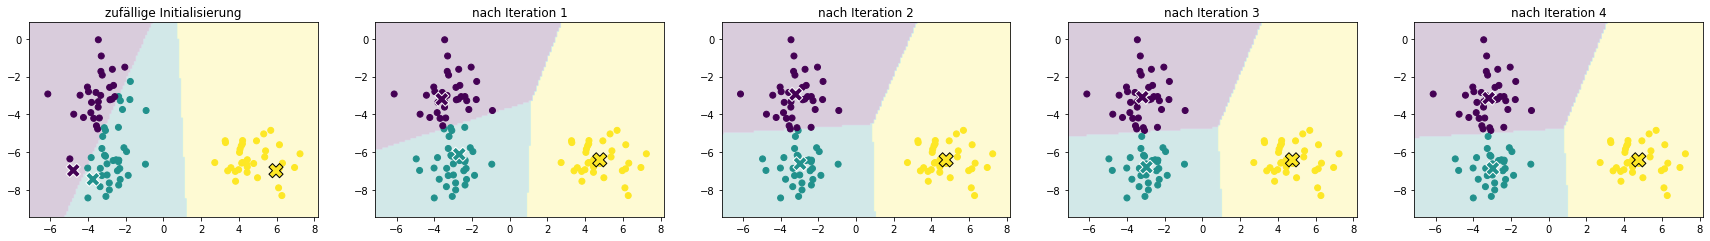

Fertig nach 4 Iterationen


In [ ]:
# Hier die Iteration der Basisfunktionen bis das Ergebnis (`membership`) sich nicht mehr ändert:

# wie viele Cluster wollen wir?
k = 3

# Zentroide willkürlich initialisieren, hier einfach die ersten k Datenpunkte
centroids = X[:k].copy()

# Initialen Zustand visualisieren
membership = assignCluster(X, centroids)
plt.figure(figsize=(30, 24))
subplot = 151  # durch ausprobieren wissen wir, dass wir 5 Bilder in einer Reihe zeichnen wollen
plt.subplot(subplot)
plt.title("zufällige Initialisierung")
plotKMeans(X, centroids, membership)

# Der eigentliche KMeans-Loop:
converged = False
iteration = 0
while (not converged and iteration < 10):
    iteration += 1

    # aktuelles Ergebnis merken und neuen Schritt berechnen
    old_membership = membership.copy()
    centroids, membership = KMeans_step(X, centroids, membership)

    # neuen Schritt visualisieren
    subplot += 1
    plt.subplot(subplot)
    plt.title("nach Iteration " + str(iteration))
    plotKMeans(X, centroids, membership)

    # prüfen ob das neue und das gemerkte Ergebnis übereinstimmen
    converged = np.min(np.equal(old_membership, membership))
    print("Iteration {}: converged: {}".format(iteration, converged))

plt.show()

print("Fertig nach {} Iterationen".format(iteration))

## Ellenbogenmethode

Bei wievielen Clustern sinkt der Fehler nur noch langsam?

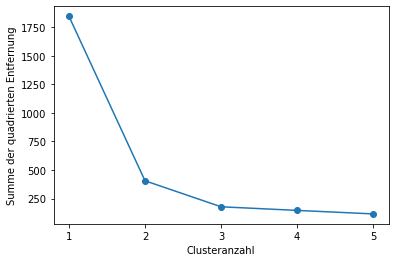

In [ ]:
# Keine Visualisierung der Zwischenschritte, nimm den K-Means Algorithmus von scikit-learn
from sklearn.cluster import KMeans

# Wir testen eins bis sechs als Anzahl für die Cluster durch
ks = range(1, 6)
errors = []

for k in ks:
    kmeans = KMeans(k)
    kmeans.fit(X)
    centroids = kmeans.cluster_centers_
    errors.append(kmeans.inertia_)

plt.xticks(ks)
plt.xlabel('Clusteranzahl')
plt.ylabel('Summe der quadrierten Entfernung')

plt.plot(ks, errors, marker='o')
plt.show()

# Clustering mit DBSCAN

Zuerst suchen wir nach sinnvollen Werte für `minPts` und `epsilon`:

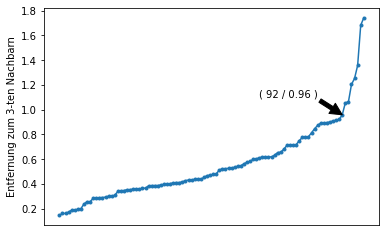

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# wir haben 2-dimensionale Daten
dim = 2

# ein guter Startpunkt für die Nachbarschaftsgröße ist demnach
minPts = 2*dim  # 4

# wir schauen für jeden Punkt wie weit der (minPts-1)te Nachbar weg ist.
nearest_neighbors = NearestNeighbors(n_neighbors=(minPts-1))
nearest_neighbors.fit(X)
distances, _ = nearest_neighbors.kneighbors(X)
distances = np.sort(distances, axis=0)[:, -1]

# Wähle einen Punkt bei epsilon ~ 1.0 aus
border_value = min(dist for dist in distances if dist >= 0.95)
border_index = np.where(distances == border_value)[0][0]

# Zeichne das Bild
plt.plot(distances, marker='.')
plt.xticks([])
plt.ylabel('Entfernung zum 3-ten Nachbarn')

# Markiere den gewählten Punkt mit einem Pfeil
plt.annotate(
    "( {} / {:.2f} )".format(border_index, border_value),
    (border_index, border_value),
    xytext=(65,1.1), arrowprops=dict(facecolor='black'))


plt.show()

Dann berechnen wir die Cluster mit Hilfe von scikit-learn

In [ ]:
epsilon = 1.0
dbscan = DBSCAN(eps=epsilon, min_samples=minPts)
clusters = dbscan.fit_predict(X)
clusters

array([ 0,  0,  1,  0, -1,  0, -1,  1,  0,  1,  0,  1,  1,  0,  1,  0,  0,
        1,  1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  1,  1,  1,  1,  0,  1,
        1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  1,  1, -1,  0,  1,  0,  0,
        0,  0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  0,  1,  1,  0,  0,  0,
        0,  1,  0,  0, -1,  1,  0,  1,  0, -1,  0,  0,  1,  0,  0,  0,  0,
        1,  0,  0,  0,  1,  0,  1,  0,  0,  0,  0,  0,  1,  0,  0],
      dtype=int64)

Nun noch die Visualisierung wie im Artikel beschrieben

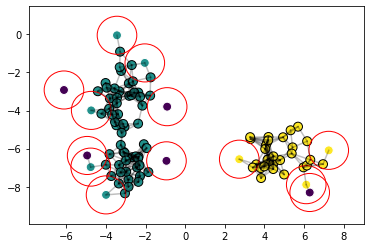

In [ ]:
# Merke dir Linien die schon gezeichnet wurden
drawn_lines = []

def relate_points(X, i, j, ax):
    'Verbindet aus den Punkten in X den i-ten mit dem j-ten im Bild ax'
    if ((i != neighbour) & ((i, neighbour) not in drawn_lines)):
        pt_i = X[i]
        pt_j = X[j]
        line = ([pt_i[0], pt_j[0]], [pt_i[1], pt_j[1]])
        ax.plot(*line, alpha=0.25, c="k")
    drawn_lines.append((i, neighbour))
    drawn_lines.append((neighbour, i))

# Finde die Kernpunkte
core_point_mask = np.zeros(len(X), dtype=bool)
core_point_mask[dbscan.core_sample_indices_] = True

# Zeichne alle Punkte und markiere Kernpunkte mit schwarzem Rand
edgecolor = ['k' if x else 'w' for x in core_point_mask]
plt.scatter(X[:,0], X[:,1], s=80, c=clusters,  edgecolors=edgecolor)

# Verbindungsgraph der Kernpunkte zeichnen
nearest_neighbors = NearestNeighbors(radius=epsilon)
nearest_neighbors.fit(X)
ax = plt.gca()
for i, x_i in enumerate(X):
    distances, neighbours = nearest_neighbors.radius_neighbors([x_i])
    for neighbour in neighbours[0]:
        relate_points(X, i, neighbour, ax)

# Radien um alle Punkte die nicht Kernpunkte sind zeichnen
radius = epsilon
non_core_points = X[~core_point_mask]
for point in non_core_points:
    circle = plt.Circle((point[0], point[1]), radius, color='r', fill=False)
    ax.add_patch(circle)

plt.show()

# Hierarchical Agglomerative Clustering

In [ ]:
# Eine Visualisierungsfunktion:
from scipy.cluster.hierarchy import dendrogram


def plot_dendrogram(hac, threshold, ax):
    'Zeichne das Dentrogram von hac und eine annotierte horizontale Linie bei threshold'
    linkage_matrix = np.column_stack([hac.children_, hac.distances_,
                                      np.zeros(hac.children_.shape[0])]).astype(float)
    dendrogram(linkage_matrix, color_threshold=threshold, ax=ax)
    ax.set(xticks=[])
    ax.plot([0,1000], [threshold, threshold], c='k')
    ax.text(10, threshold*1.05, str(threshold))

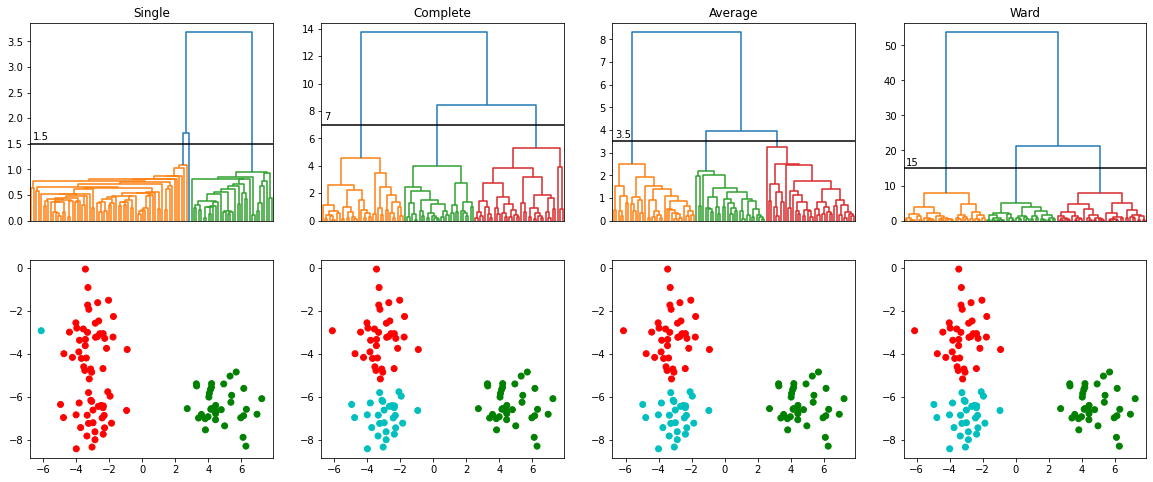

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap

# eine Grafik aus zwei Zeilen mit vier Spalten
fig, axes = plt.subplots(2,4, figsize=(20, 8))

for column, linkage, threshold in zip(
                range(4),  # Spaltenindex
                ['single', 'complete', 'average', 'ward'],  # die Linkage Criteria
                [1.5, 7, 3.5, 15]):  # dazu passende Thresholds für 3 Cluster

    # Berechne das Clustering über die komplete Hierarchy (distance_threshold=0)
    hac = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage=linkage)
    hac.fit(X)

    # Berechne das Clustering für drei Cluster
    clusters = AgglomerativeClustering(n_clusters=3, linkage=linkage).fit_predict(X)

    # Zeichne das Dentrogram in die erste Zeile 
    axes[0][column].set_title(str.capitalize(linkage))
    plot_dendrogram(hac, threshold, axes[0][column])

    # Zeichne das Streudiagram in die zweite Zeile
    axes[1][column].scatter(
        X[:,0], X[:,1], c=clusters, cmap=ListedColormap(['r', 'g', 'c']))

plt.show()